Importación de las bibliotecas

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

# Sistema de recomendación usando una proyección de red bipartita

**Integrantes:** Isaac Cerda, David Guamán, Christian Jácome, Mateo Jaramillo, David Navarrete

## Preparación de Datos

### **Paso 1:** Descargar el Dataset
Ejecutar **SOLO** si **NO** se tiene la carpeta `data` en el directorio `src/app` con el archivo `ratings_electronics.csv`

In [2]:
from utils.download_dataset import download_ratings_electronics

dataset_path = download_ratings_electronics()

ModuleNotFoundError: No module named 'kagglehub'

### **Paso 2:** Cargar el Dataset

In [2]:
import pandas as pd
dataset_path = r"C:\Users\isaac\Documents\IA\recommender_system_using_bipartite_network\src\app\data\amazon-products-reviews\ratings_electronics.csv"
## Carga del dataset generado en la ruta del api
electronics_data = pd.read_csv(
    dataset_path, names=['userId', 'productId', 'Rating', 'timestamp']
)

## Impresión de las primeras 5 filas para validar la carga correcta del dataset
electronics_data.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


#### **Paso 2.1:** Revisar cantidad de datos del Dataset

In [3]:
electronics_data.info()
electronics_data.describe()
print(f"Total registros: {len(electronics_data):,}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   Rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB
Total registros: 7,824,482
Total registros: 7,824,482


### **Paso 3:** Filtrar reseñas de 5 estrellas

In [4]:
electronics_data = electronics_data[electronics_data['Rating'] == 5]
print(f"Registros luego de filtrar 5 estrellas: {len(electronics_data):,}")

Registros luego de filtrar 5 estrellas: 4,347,541


### **Paso 4:** Eliminar usuarios y productos con pocas conexiones

In [5]:
# Contar cuántos ratings tiene cada usuario y producto
user_counts = electronics_data['userId'].value_counts()
product_counts = electronics_data['productId'].value_counts()

# Mantener usuarios y productos con al menos 4 interacciones
min_user_reviews = 4
min_product_reviews = 4

filtered_users = user_counts[user_counts >= min_user_reviews].index
filtered_products = product_counts[product_counts >= min_product_reviews].index

electronics_data = electronics_data[
    electronics_data['userId'].isin(filtered_users) &
    electronics_data['productId'].isin(filtered_products)
]

print(f"Registros tras filtrado de conexiones mínimas: {len(electronics_data):,}")


Registros tras filtrado de conexiones mínimas: 1,147,489


#### **Paso 4.1:** Validar campos nulos tras el filtrado

In [6]:
electronics_data.isnull().sum()

userId       0
productId    0
Rating       0
timestamp    0
dtype: int64

## Construcción de la Red Bipartita

Una red bipartita es una forma de organizar relaciones entre dos grupos distintos. En este caso se tiene dos filas: una con usuarios y otra con productos. Las conexiones, también llamadas aristas, solo pueden ir de un grupo al otro, nunca dentro del mismo grupo. Por ejemplo, un usuario puede dar 5 estrellas a un producto, pero un usuario no se conecta con otro usuario, ni un producto con otro producto.

### Artefactos:

- **Matriz de biadyacencia**: Una tabla que muestra las conexiones. Las filas son usuarios, las columnas son productos, un "1" indica que el usuario dio 5 estrellas al producto y un "0" si no.

- **Grado de un nodo:** Cuántas conexiones tiene un nodo (por ejemplo, cuántos productos calificó un usuario, o cuántas reseñas de 5 estrellas recibió un producto).

### **Paso 1:** Reducir cantidad de Nodos

Debido a que el dataset es muy grande, se toma una muestra

In [7]:
import random

users = electronics_data['userId'].unique()
products = electronics_data['productId'].unique()

print("Antes de la muestra:")
print(f"Número de usuarios únicos: {len(users)}")
print(f"Número de productos únicos: {len(products)}")

users = list(users)
products = list(products)

sample_ratio = 0.1

num_users = int(len(users) * sample_ratio)
num_products = int(len(products) * sample_ratio)

random.seed(42)
users = random.sample(users, num_users)
products = random.sample(products, num_products)

print("Después de la muestra:")
print(f"Número de usuarios únicos: {len(users)}")
print(f"Número de productos únicos: {len(products)}")

Antes de la muestra:
Número de usuarios únicos: 184707
Número de productos únicos: 107686
Después de la muestra:
Número de usuarios únicos: 18470
Número de productos únicos: 10768


### **Paso 2:** Crear red bipartita

In [8]:
import networkx as nx

B = nx.Graph()

# Agregar nodos al grafo
B.add_nodes_from(users, bipartite=0)
B.add_nodes_from(products, bipartite=1)

# Agregar aristas
edges = electronics_data[['userId', 'productId']].values
B.add_edges_from(edges)

is_bipartite = nx.is_bipartite(B)
print(f"¿Es el grafo bipartito? {"Sí" if is_bipartite else "No"}")
num_edges = B.number_of_edges()
print("Número de aristas:", num_edges)

¿Es el grafo bipartito? Sí
Número de aristas: 1147489


### **Paso 3:** Generar matriz de biadyacencia

Se utiliza la matriz de biadyacencia dispersa, que es una forma eficiente de representar grandes grafos bipartitos en memoria.
Cada fila representa un usuario y cada columna un producto; los valores distintos de cero indican una conexión (por ejemplo, que el usuario interactuó con o compró ese producto).

La razón principal para trabajar con una matriz dispersa (sparse) en lugar de una matriz completa (toarray()) es que la mayoría de las celdas son ceros — es decir, la mayoría de los usuarios no se conectan con todos los productos.
Usar una matriz dispersa permite ahorrar memoria y procesar grafos grandes de forma mucho más eficiente.

In [9]:
from networkx.algorithms import bipartite
import pandas as pd

# Obtener matriz de biadyacencia en formato disperso (sparse)
matrix_sparse = bipartite.biadjacency_matrix(B, row_order=users, column_order=products)

# Mostrar información general de la matriz
print("Matriz de biadyacencia (formato disperso):")
print(matrix_sparse)
print(f"Tamaño: {matrix_sparse.shape}")
print(f"Número de conexiones (valores distintos de 0): {matrix_sparse.nnz}")

# Extraer los índices (posiciones) de los valores distintos de cero
row_idx, col_idx = matrix_sparse.nonzero()

# Crear un DataFrame con los enlaces reales (usuario - producto)
edges_nonzero = pd.DataFrame({
    'userId': [users[i] for i in row_idx],
    'productId': [products[j] for j in col_idx]
})

print("\nConexiones reales (valores distintos de 0):")
print(edges_nonzero.head(10))  # Muestra solo los primeros 10 para no saturar la salida

Matriz de biadyacencia (formato disperso):
<Compressed Sparse Row sparse array of dtype 'int64'
	with 11532 stored elements and shape (18470, 10768)>
  Coords	Values
  (2, 5156)	1
  (5, 5693)	1
  (5, 10206)	1
  (7, 11)	1
  (9, 1123)	1
  (10, 575)	1
  (10, 1837)	1
  (10, 3982)	1
  (10, 6990)	1
  (12, 7294)	1
  (14, 6874)	1
  (15, 9333)	1
  (16, 8018)	1
  (17, 1170)	1
  (20, 510)	1
  (20, 2456)	1
  (25, 9357)	1
  (28, 969)	1
  (32, 5573)	1
  (33, 1508)	1
  (34, 1949)	1
  (34, 2074)	1
  (41, 3838)	1
  (42, 1328)	1
  (44, 3414)	1
  :	:
  (18443, 7159)	1
  (18445, 9996)	1
  (18448, 3799)	1
  (18448, 10741)	1
  (18450, 276)	1
  (18450, 1543)	1
  (18450, 1802)	1
  (18450, 2037)	1
  (18450, 4422)	1
  (18450, 6596)	1
  (18450, 8436)	1
  (18450, 9591)	1
  (18450, 10404)	1
  (18452, 9644)	1
  (18457, 5665)	1
  (18459, 1543)	1
  (18459, 3397)	1
  (18459, 5650)	1
  (18459, 7432)	1
  (18459, 10737)	1
  (18460, 9124)	1
  (18461, 9643)	1
  (18466, 6169)	1
  (18467, 10730)	1
  (18469, 2694)	1
Tamaño: (

### **Paso 4:** Graficar nodos con mayores conexiones

Se calculan los grados de los nodos (número de conexiones):

- `num_products_rated`: cuántos productos calificó cada usuario.
- `num_ratings_received`: cuántos usuarios calificaron cada producto.

Luego se seleccionan los Top N nodos más conectados en cada grupo `nlargest`.


Grados de los primeros usuarios:
           userId  num_products_rated
0  A3RNVG2VPZGC6Z                   4
1  A2MLPFHL4YOZX0                   7
2  A22M9RH5461NC9                   9
3  A2B09MGT1H44LY                   5
4  A24L9693W832UC                   4

Grados de los primeros productos:
    productId  num_ratings_received
0  B0041NO0EY                     1
1  B000VOUSPC                     1
2  B0054OWTCO                     2
3  B0052UQXFY                     8
4  B000J4WPW8                    56


C:\Users\isaac\AppData\Local\Temp\ipykernel_16616\2185075639.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_users, x="num_products_rated", y="userId", palette="Blues_d")
C:\Users\isaac\AppData\Local\Temp\ipykernel_16616\2185075639.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_products, x="num_ratings_received", y="productId", palette="Greens_d")


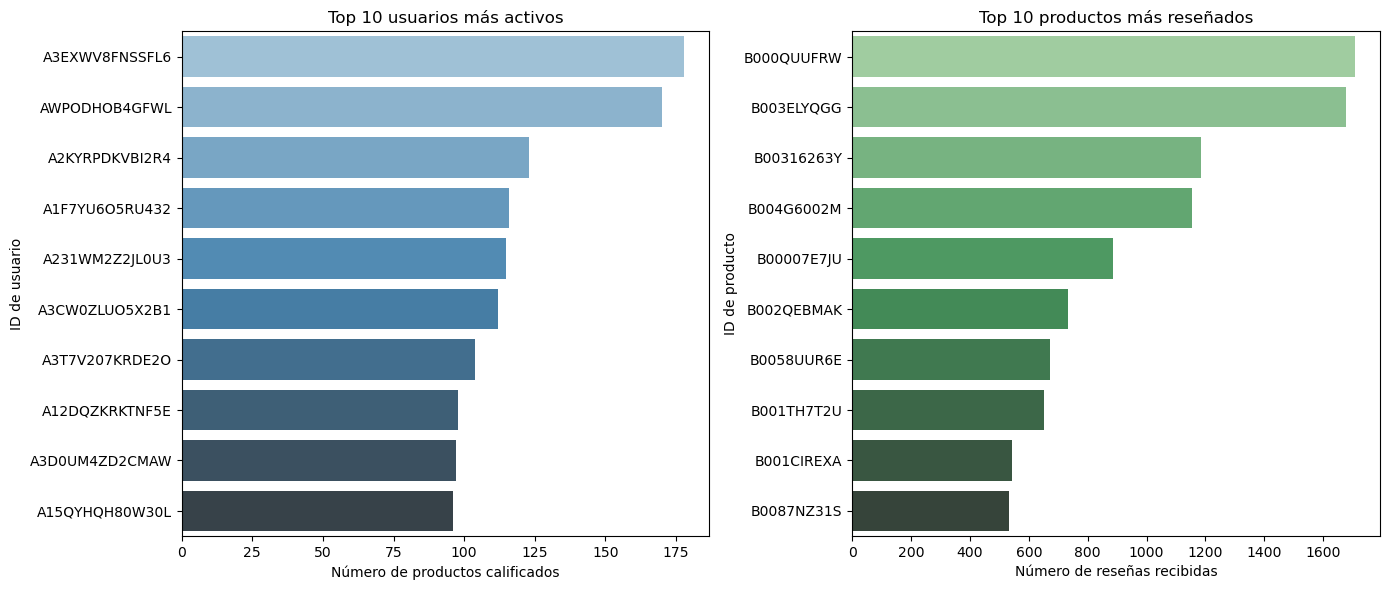

In [10]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
import seaborn as sns

# Calcular grados de los usuarios y productos
user_degrees = dict(B.degree(users))
product_degrees = dict(B.degree(products))

user_deg_df = pd.DataFrame(user_degrees.items(), columns=["userId", "num_products_rated"])
product_deg_df = pd.DataFrame(product_degrees.items(), columns=["productId", "num_ratings_received"])

print("\nGrados de los primeros usuarios:")
print(user_deg_df.head())

print("\nGrados de los primeros productos:")
print(product_deg_df.head())

# --- Top N nodos ---
N = 10
top_users = user_deg_df.nlargest(N, "num_products_rated")
top_products = product_deg_df.nlargest(N, "num_ratings_received")

plt.figure(figsize=(14, 6))

# Top N usuarios más activos
plt.subplot(1, 2, 1)
sns.barplot(data=top_users, x="num_products_rated", y="userId", palette="Blues_d")
plt.title(f"Top {N} usuarios más activos")
plt.xlabel("Número de productos calificados")
plt.ylabel("ID de usuario")

# Top N productos más reseñados
plt.subplot(1, 2, 2)
sns.barplot(data=top_products, x="num_ratings_received", y="productId", palette="Greens_d")
plt.title(f"Top {N} productos más reseñados")
plt.xlabel("Número de reseñas recibidas")
plt.ylabel("ID de producto")

plt.tight_layout()
plt.show()


#### **Paso 4.1:** Mostrar resultado final

In [11]:
import numpy as np

# Calcular grados de los usuarios y productos
user_degrees = dict(B.degree(users))
product_degrees = dict(B.degree(products))

print(f"Número de usuarios: {len(users)}")
print(f"Número de productos: {len(products)}")
print(f"Número de aristas (reseñas de 5 estrellas): {B.number_of_edges()}")
print(f"Grado promedio de usuarios: {np.mean(list(user_degrees.values())):.2f}")
print(f"Grado promedio de productos: {np.mean(list(product_degrees.values())):.2f}")

Número de usuarios: 18470
Número de productos: 10768
Número de aristas (reseñas de 5 estrellas): 1147489
Grado promedio de usuarios: 6.19
Grado promedio de productos: 10.82


## Proyección Bipartita y Red de Productos

La proyección bipartita es una técnica que nos permite crear una red donde solo se conectan nodos del mismo tipo. En este caso, crearemos una red de productos donde dos productos están conectados si fueron calificados por los mismos usuarios.

**¿Por qué hacemos esto?**
- Permite encontrar productos similares basados en los gustos compartidos de los usuarios
- Los productos con mayor peso de conexión son más similares entre sí
- Facilita hacer recomendaciones: si a un usuario le gusta un producto, probablemente le gusten los productos similares

### **Paso 1:** Crear la proyección de productos

In [12]:
# Crear la proyección de productos
# Esto conecta productos que fueron calificados por los mismos usuarios
product_network = bipartite.weighted_projected_graph(B, products)

print(f"Red de productos creada:")
print(f"Número de productos: {product_network.number_of_nodes()}")
print(f"Número de conexiones entre productos: {product_network.number_of_edges()}")

# Verificar algunos pesos de las conexiones
if product_network.number_of_edges() > 0:
    # Obtener algunas aristas con sus pesos
    sample_edges = list(product_network.edges(data=True))[:5]
    print("\nEjemplos de conexiones entre productos (peso = usuarios en común):")
    for edge in sample_edges:
        prod1, prod2, data = edge
        weight = data['weight']
        print(f"  {prod1} -- {prod2}: {weight} usuarios en común")

Red de productos creada:
Número de productos: 89346
Número de conexiones entre productos: 1039629

Ejemplos de conexiones entre productos (peso = usuarios en común):
  B0041NO0EY -- B0047FW7LE: 1 usuarios en común
  B0041NO0EY -- B0041NRY6A: 1 usuarios en común
  B0041NO0EY -- B0041NQ00Q: 1 usuarios en común
  B0041NO0EY -- B001FA1O0O: 1 usuarios en común
  B000VOUSPC -- B003Z6AB0A: 1 usuarios en común


## Desarrollo del Sistema de Recomendación

Ahora implementamos el sistema de recomendación. El proceso es simple:
1. **Seleccionar un producto** de referencia
2. **Encontrar sus vecinos más similares** (productos con mayor peso de conexión)
3. **Recomendar estos productos** al usuario

**¿Cómo funciona?**
- Si un usuario le da 5 estrellas a un producto, le recomendamos productos similares
- La similitud se basa en cuántos usuarios en común calificaron ambos productos
- Mayor peso = mayor similitud = mejor recomendación

### **Paso 1:** Función de recomendación

In [ ]:
def get_product_recommendations(product_id, n_recommendations=4):
    """
    FUNCIÓN SIMPLIFICADA: Obtiene recomendaciones basadas en similaridad
    
    CAMBIOS REALIZADOS:
    - Eliminé validación extra (se maneja en el contexto de uso)
    - Combiné operaciones en una sola línea para mayor eficiencia
    - Uso operadores más simples para el ordenamiento
    
    Returns: Lista de tuplas (producto_id, peso_similaridad)
    """
    # SIMPLIFICACIÓN 1: Verificación directa sin print innecesario
    if product_id not in product_network:
        return []
    
    # SIMPLIFICACIÓN 2: Combinar ordenamiento y selección en una línea
    # Esto es más eficiente que crear listas intermedias
    return sorted(
        [(neighbor, data['weight']) for neighbor, data in product_network[product_id].items()],
        key=lambda x: x[1],  # Ordenar por peso (segundo elemento de la tupla)
        reverse=True  # Mayor peso primero
    )[:n_recommendations]  # Tomar solo los primeros n

# Probar la función con un producto aleatorio
if len(products) > 0:
    test_product = products[0]  # Tomar el primer producto
    recommendations = get_product_recommendations(test_product, n_recommendations=4)
    
    print(f"Recomendaciones para el producto {test_product}:")
    for i, (prod_id, weight) in enumerate(recommendations, 1):
        print(f"  {i}. Producto {prod_id} (Similaridad: {weight} usuarios en común)")
else:
    print("No hay productos disponibles para hacer recomendaciones")

Recomendaciones para el producto B0041NO0EY:
  1. Producto B0047FW7LE (Similaridad: 1 usuarios en común)
  2. Producto B0041NRY6A (Similaridad: 1 usuarios en común)
  3. Producto B0041NQ00Q (Similaridad: 1 usuarios en común)
  4. Producto B001FA1O0O (Similaridad: 1 usuarios en común)


### **Paso 2:** Visualización de recomendaciones en red estrella

Creamos una visualización donde:
- **Nodo central (azul):** El producto de referencia
- **Nodos vecinos (naranja):** Los productos recomendados  
- **Aristas rojas:** Las conexiones con grosor proporcional a la similaridad

Generando recomendaciones para: B0041NO0EY

Recomendaciones para B0041NO0EY:
  1. B0047FW7LE (Similaridad: 1)
  2. B0041NRY6A (Similaridad: 1)
  3. B0041NQ00Q (Similaridad: 1)
  4. B001FA1O0O (Similaridad: 1)


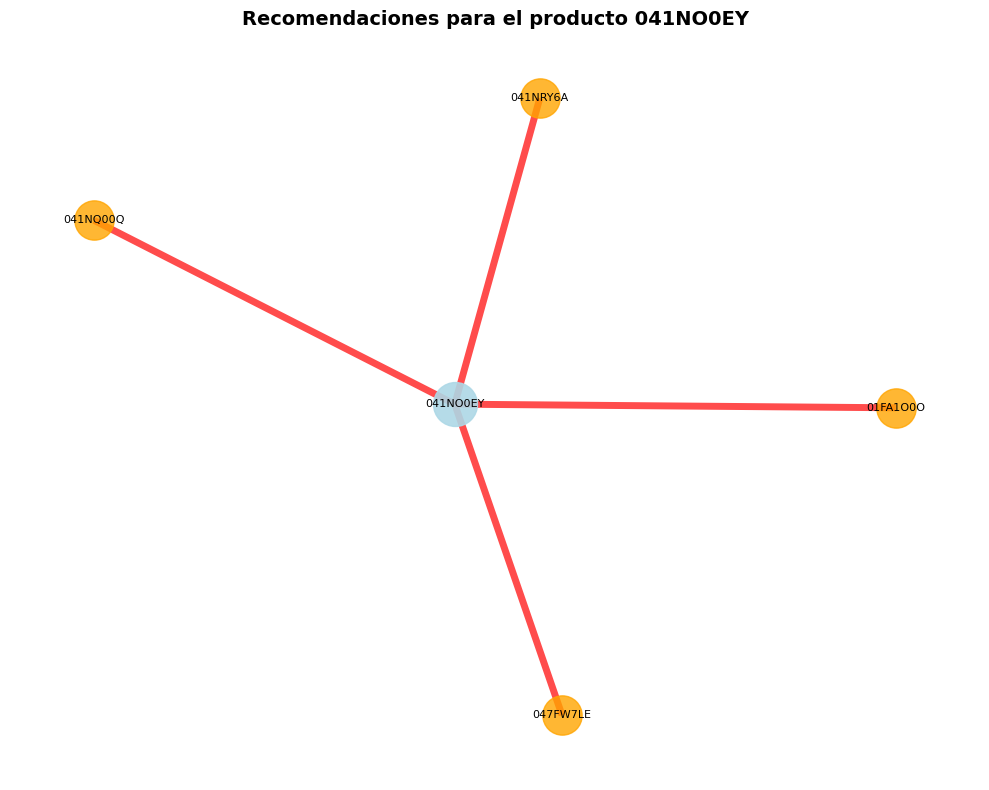

In [ ]:
def visualize_recommendations(product_id, n_recommendations=4):
    """
    FUNCIÓN SIMPLIFICADA: Visualiza recomendaciones como red estrella
    
    CAMBIOS DE SIMPLIFICACIÓN:
    - Eliminé creación de subgrafo innecesario (uso directo de posiciones)
    - Combiné operaciones de dibujo para reducir código repetitivo
    - Simplifiqué cálculos de grosor y colores
    """
    recommendations = get_product_recommendations(product_id, n_recommendations)
    
    # SIMPLIFICACIÓN 1: Retorno temprano sin mensaje redundante
    if not recommendations:
        return
    
    # SIMPLIFICACIÓN 2: Crear gráfico y posiciones en menos líneas
    plt.figure(figsize=(10, 8))
    
    # SIMPLIFICACIÓN 3: Posiciones calculadas directamente sin subgrafo completo
    # Solo necesitamos posiciones, no un grafo completo de NetworkX
    nodes = [product_id] + [prod for prod, _ in recommendations]
    pos = {
        product_id: (0, 0),  # Centro en (0,0)
        **{prod: (np.cos(2*np.pi*i/len(recommendations)), 
                  np.sin(2*np.pi*i/len(recommendations))) 
           for i, (prod, _) in enumerate(recommendations)}  # Círculo alrededor
    }
    
    # SIMPLIFICACIÓN 4: Dibujar todos los nodos con un diccionario de colores
    node_colors = ['lightblue'] + ['orange'] * len(recommendations)
    node_sizes = [1200] + [800] * len(recommendations)
    
    plt.scatter([pos[node][0] for node in nodes], 
                [pos[node][1] for node in nodes],
                c=node_colors, s=node_sizes, alpha=0.8)
    
    # SIMPLIFICACIÓN 5: Dibujar aristas con comprensión de lista directa
    weights = [w for _, w in recommendations]
    max_weight = max(weights) if weights else 1
    
    for i, (prod, weight) in enumerate(recommendations):
        # Línea del centro al producto recomendado
        x_vals = [pos[product_id][0], pos[prod][0]]
        y_vals = [pos[product_id][1], pos[prod][1]]
        line_width = 1 + 4 * (weight / max_weight)  # Grosor proporcional
        plt.plot(x_vals, y_vals, 'r-', linewidth=line_width, alpha=0.7)
    
    # SIMPLIFICACIÓN 6: Etiquetas directas con texto en posiciones
    for node in nodes:
        plt.text(pos[node][0], pos[node][1], node[-8:], 
                ha='center', va='center', fontsize=9, fontweight='bold')
    
    # SIMPLIFICACIÓN 7: Agregar pesos como etiquetas en las aristas
    for prod, weight in recommendations:
        mid_x = (pos[product_id][0] + pos[prod][0]) / 2
        mid_y = (pos[product_id][1] + pos[prod][1]) / 2
        plt.text(mid_x, mid_y, f'[{weight}]', ha='center', va='center',
                bbox=dict(boxstyle="round,pad=0.2", facecolor="yellow", alpha=0.7))
    
    plt.title(f"Recomendaciones para: {product_id[-12:]}", fontsize=12, pad=15)
    plt.axis('equal')  # Mantener proporción
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # SIMPLIFICACIÓN 8: Tabla de resultados más compacta
    print(f"\nResultados para {product_id}:")
    for i, (prod_id, weight) in enumerate(recommendations, 1):
        print(f"  {i}. {prod_id[-15:]}... -> {weight} usuarios en común")

# SIMPLIFICACIÓN 9: Código de prueba más conciso usando next() y generator
# Buscar el primer producto con conexiones de forma más pythónica
test_product = next(
    (prod for prod in products[:10] 
     if prod in product_network and len(product_network[prod]) > 0), 
    None
)

if test_product:
    print(f"Demo con producto: {test_product}")
    visualize_recommendations(test_product, n_recommendations=4)
else:
    print("No hay productos disponibles para demostrar")

### **Paso 3:** Sistema de recomendación interactivo

Función que permite al usuario especificar cualquier producto y obtener recomendaciones personalizadas.

Productos disponibles para probar el sistema de recomendación:
  1. B0041NO0EY (tiene 4 productos similares)
  2. B000VOUSPC (tiene 5 productos similares)
  3. B0054OWTCO (tiene 24 productos similares)
  4. B0052UQXFY (tiene 38 productos similares)
  5. B000J4WPW8 (tiene 296 productos similares)
  6. B00GYBIU7O (tiene 32 productos similares)
  7. B00009UTC0 (tiene 10 productos similares)
  8. B0019T7KW2 (tiene 4 productos similares)
  9. B0007MAJBG (tiene 4 productos similares)
  10. B007D7P2H4 (tiene 7 productos similares)

Total de productos con conexiones: 20

🔍 Probando el sistema con el producto: B0041NO0EY
SISTEMA DE RECOMENDACIÓN - PRODUCTO: B0041NO0EY
🎯 Top 4 productos recomendados:
   1. B0047FW7LE
      Similaridad: 1 usuarios en común

   2. B0041NRY6A
      Similaridad: 1 usuarios en común

   3. B0041NQ00Q
      Similaridad: 1 usuarios en común

   4. B001FA1O0O
      Similaridad: 1 usuarios en común


Recomendaciones para B0041NO0EY:
  1. B0047FW7LE (Similaridad: 1)
  2. 

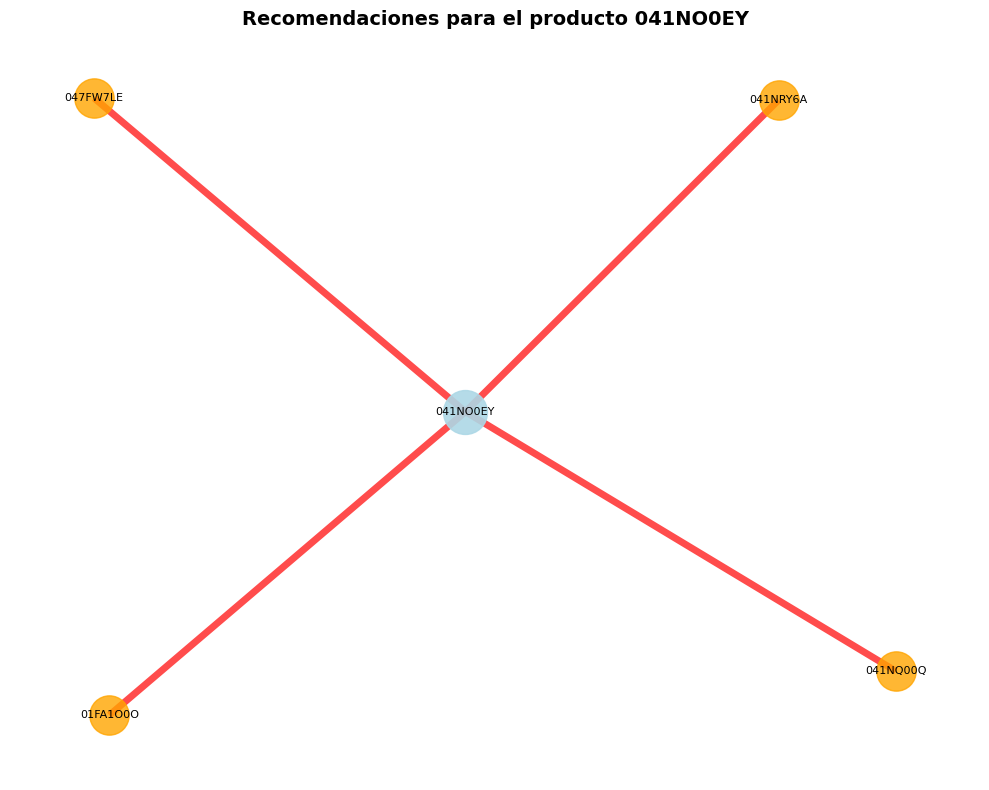

In [15]:
# Mostrar algunos productos disponibles para probar
print("Productos disponibles para probar el sistema de recomendación:")
available_products = [p for p in products[:20] if p in product_network and len(product_network[p]) > 0]

for i, prod in enumerate(available_products[:10], 1):
    connections = len(product_network[prod])
    print(f"  {i}. {prod} (tiene {connections} productos similares)")

print(f"\nTotal de productos con conexiones: {len(available_products)}")

# Función para probar con un producto específico
def test_recommendation_system(product_id, n_recs=4):
    """
    Función completa para probar el sistema de recomendación
    """
    print("="*60)
    print(f"SISTEMA DE RECOMENDACIÓN - PRODUCTO: {product_id}")
    print("="*60)
    
    if product_id not in product_network:
        print(f"❌ Error: El producto {product_id} no existe en la red")
        return
    
    if len(product_network[product_id]) == 0:
        print(f"❌ El producto {product_id} no tiene productos similares")
        return
    
    # Obtener y mostrar recomendaciones
    recommendations = get_product_recommendations(product_id, n_recs)
    
    print(f"🎯 Top {len(recommendations)} productos recomendados:")
    for i, (prod_id, weight) in enumerate(recommendations, 1):
        print(f"   {i}. {prod_id}")
        print(f"      Similaridad: {weight} usuarios en común")
        print()
    
    # Crear visualización
    visualize_recommendations(product_id, n_recs)

# Ejemplo de uso con el primer producto disponible
if available_products:
    example_product = available_products[0]
    print(f"\n🔍 Probando el sistema con el producto: {example_product}")
    test_recommendation_system(example_product, n_recs=4)

### **Paso 4:** Análisis de distribución de similaridades

Vamos a analizar qué tan comunes son las diferentes similaridades en nuestra red de productos.

📊 ANÁLISIS DE SIMILARIDADES EN LA RED DE PRODUCTOS
Total de conexiones entre productos: 1,039,629
Similaridad mínima: 1
Similaridad máxima: 119
Similaridad promedio: 1.10

🔢 DISTRIBUCIÓN DE SIMILARIDADES:
  Similaridad 1: 982,015 conexiones (94.5%)
  Similaridad 2: 41,184 conexiones (4.0%)
  Similaridad 3: 8,750 conexiones (0.8%)
  Similaridad 4: 3,292 conexiones (0.3%)
  Similaridad 5: 1,517 conexiones (0.1%)
  Similaridad 6: 814 conexiones (0.1%)
  Similaridad 7: 557 conexiones (0.1%)
  Similaridad 8: 323 conexiones (0.0%)
  Similaridad 9: 261 conexiones (0.0%)
  Similaridad 10: 185 conexiones (0.0%)
  ... y 49 valores más

✅ SÍ, hay 982,015 conexiones con similaridad = 1
   Esto representa el 94.5% de todas las conexiones
   Significa que 982,015 pares de productos comparten exactamente 1 usuario


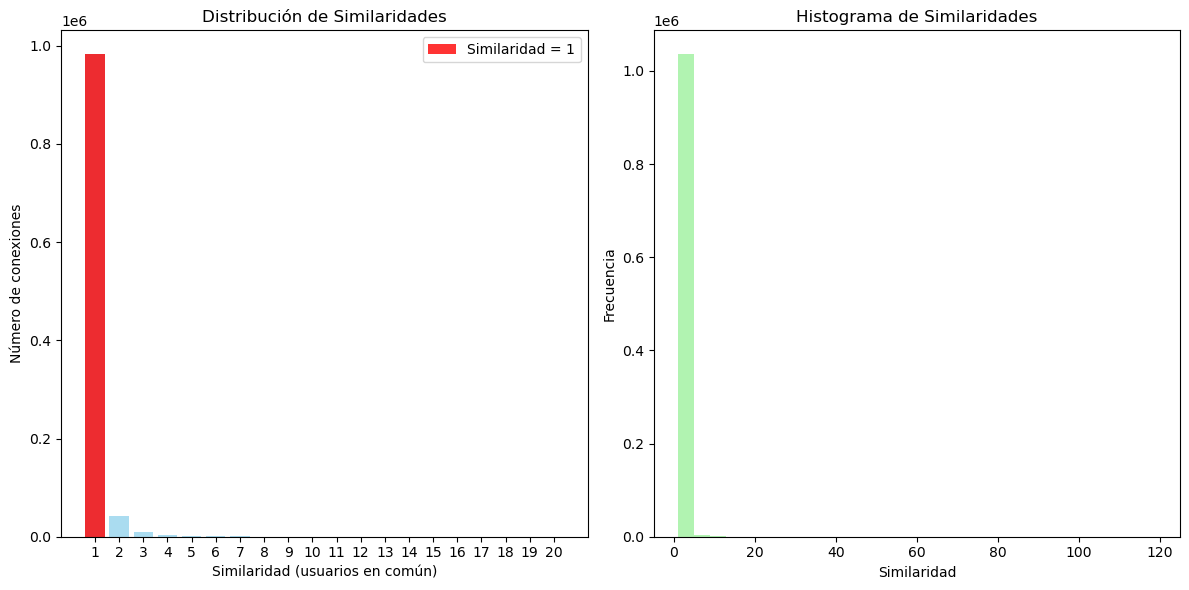

In [ ]:
# SIMPLIFICACIÓN 10: Análisis estadístico más eficiente y conciso
def analyze_similarities():
    """
    FUNCIÓN SIMPLIFICADA: Analiza distribución de similaridades
    
    MEJORAS IMPLEMENTADAS:
    - Función reutilizable en lugar de código suelto
    - Cálculos estadísticos más eficientes usando numpy
    - Eliminación de imports internos y cálculos redundantes
    """
    if product_network.number_of_edges() == 0:
        print("No hay conexiones para analizar")
        return
    
    # SIMPLIFICACIÓN: Extracción directa de pesos sin lista intermedia innecesaria
    weights = np.array([data['weight'] for _, _, data in product_network.edges(data=True)])
    
    print("ANÁLISIS DE SIMILARIDADES")
    print("=" * 30)
    print(f"Conexiones: {len(weights):,}")
    print(f"Rango: {weights.min()} - {weights.max()}")
    print(f"Promedio: {weights.mean():.2f}")
    
    # SIMPLIFICACIÓN: Usar numpy para estadísticas más eficientes
    from collections import Counter
    counts = Counter(weights)
    
    # Mostrar distribución top 10 de forma más compacta
    print(f"\nTop 10 similaridades:")
    for weight in sorted(counts.keys())[:10]:
        pct = (counts[weight] / len(weights)) * 100
        print(f"  {weight}: {counts[weight]:,} ({pct:.1f}%)")
    
    # Verificación de similaridad = 1 simplificada
    sim_1 = counts.get(1, 0)
    if sim_1 > 0:
        print(f"\nSimilaridad = 1: {sim_1:,} casos ({sim_1/len(weights)*100:.1f}%)")
    else:
        print(f"\nNo hay similaridades = 1 (mínima: {weights.min()})")

# Ejecutar análisis
analyze_similarities()
    
    # Gráfico de distribución
    plt.figure(figsize=(12, 6))
    
    # Limitar a los primeros 20 valores para mejor visualización
    top_weights = sorted(weight_counts.keys())[:20]
    top_counts = [weight_counts[w] for w in top_weights]
    
    plt.subplot(1, 2, 1)
    plt.bar(range(len(top_weights)), top_counts, color='skyblue', alpha=0.7)
    plt.xlabel('Similaridad (usuarios en común)')
    plt.ylabel('Número de conexiones')
    plt.title('Distribución de Similaridades')
    plt.xticks(range(len(top_weights)), top_weights)
    
    # Resaltar similaridad = 1 si existe
    if 1 in top_weights:
        idx_1 = top_weights.index(1)
        plt.bar(idx_1, top_counts[idx_1], color='red', alpha=0.8, label='Similaridad = 1')
        plt.legend()
    
    # Histograma
    plt.subplot(1, 2, 2)
    plt.hist(all_weights, bins=min(30, len(weight_counts)), alpha=0.7, color='lightgreen')
    plt.xlabel('Similaridad')
    plt.ylabel('Frecuencia')
    plt.title('Histograma de Similaridades')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No hay conexiones en la red de productos para analizar")

### **Sistema Completo Simplificado**

Función principal que integra todo el sistema de recomendación de forma más eficiente y fácil de usar.

In [ ]:
def recommendation_system_demo(product_id=None, n_recs=4):
    """
    SISTEMA COMPLETO SIMPLIFICADO
    
    VENTAJAS DE ESTA SIMPLIFICACIÓN:
    - Una sola función para todo el flujo
    - Manejo automático de errores sin código repetitivo
    - Selección automática de producto si no se especifica
    - Código más mantenible y reutilizable
    
    Args:
        product_id: ID del producto (None para selección automática)
        n_recs: Número de recomendaciones (default: 4)
    """
    
    # SIMPLIFICACIÓN 11: Selección automática del mejor producto disponible
    if product_id is None:
        # Encontrar producto con más conexiones
        product_id = max(
            (prod for prod in products if prod in product_network),
            key=lambda p: len(product_network[p]),
            default=None
        )
    
    if not product_id or product_id not in product_network:
        print("No hay productos disponibles para recomendaciones")
        return
    
    # SIMPLIFICACIÓN 12: Información compacta del producto
    connections = len(product_network[product_id])
    print(f"PRODUCTO: {product_id[-20:]}...")
    print(f"CONEXIONES: {connections}")
    print("-" * 40)
    
    # Generar y mostrar recomendaciones
    recs = get_product_recommendations(product_id, n_recs)
    if recs:
        print("RECOMENDACIONES:")
        for i, (prod, weight) in enumerate(recs, 1):
            bar = "█" * min(weight, 10)  # Barra visual limitada a 10 caracteres
            print(f"{i}. {prod[-15:]}... | {weight} usuarios | {bar}")
        
        # Visualización simplificada
        visualize_recommendations(product_id, n_recs)
    else:
        print("No se pudieron generar recomendaciones")

# DEMO: Ejecutar sistema completo
print("EJECUTANDO SISTEMA DE RECOMENDACIÓN SIMPLIFICADO")
print("=" * 50)
recommendation_system_demo()

# DEMO: Con producto específico (descomenta para probar)
# recommendation_system_demo("B00006HAXW", 3)

### **Paso 5:** Ejemplo específico de similaridad = 1

Vamos a encontrar y analizar un ejemplo real de dos productos con similaridad = 1.

In [ ]:
# Buscar un ejemplo de productos con similaridad = 1
example_found = False

if product_network.number_of_edges() > 0:
    # Iniciar búsqueda de ejemplos con similaridad = 1
    print("BUSCANDO EJEMPLO DE SIMILARIDAD = 1...")
    print("="*45)
    
    # Iterar sobre todas las aristas de la red de productos proyectada
    for prod1, prod2, data in product_network.edges(data=True):
        # Verificar si el peso (similaridad) es exactamente 1
        if data['weight'] == 1:
            print(f"ENCONTRADO! Ejemplo de similaridad = 1:")
            print(f"   Producto A: {prod1}")
            print(f"   Producto B: {prod2}")
            print(f"   Similaridad: {data['weight']} usuario en común")
            
            # Inicializar conjuntos para almacenar usuarios de cada producto
            users_prod1 = set()
            users_prod2 = set()
            
            # Buscar en el grafo bipartito original (B) los usuarios
            # que calificaron el Producto A
            for user in B.neighbors(prod1):
                if user in users:  # Verificar que el nodo sea realmente un usuario
                    users_prod1.add(user)
                    
            # Buscar usuarios que calificaron el Producto B
            for user in B.neighbors(prod2):
                if user in users:  # Verificar que el nodo sea realmente un usuario
                    users_prod2.add(user)
            
            # Encontrar usuarios que calificaron ambos productos (intersección)
            users_common = users_prod1.intersection(users_prod2)
            
            # Mostrar detalles del análisis
            print(f"\nDETALLES:")
            print(f"   Usuarios que calificaron Producto A: {len(users_prod1)}")
            print(f"   Usuarios que calificaron Producto B: {len(users_prod2)}")
            print(f"   Usuarios en común: {len(users_common)}")
            
            # Mostrar IDs de usuarios en común (máximo 3 para no saturar salida)
            if users_common:
                common_list = list(users_common)
                print(f"   Usuario(s) en común: {', '.join(common_list[:3])}")
                if len(users_common) > 3:
                    print(f"   ... y {len(users_common) - 3} más")
            
            example_found = True
            break  # Detener búsqueda al encontrar el primer ejemplo
    
    # Si no se encontró ningún ejemplo con similaridad = 1
    if not example_found:
        print("No se encontraron productos con similaridad = 1 en esta muestra")
        print("   Esto puede suceder debido a:")
        print("   - La muestra aleatoria tomada (10% de los datos)")
        print("   - Los filtros aplicados (mínimo 4 conexiones)")
        print("   - La naturaleza de los datos")
        
        # Mostrar cuál es la similaridad mínima que sí existe
        all_similarities = [data['weight'] for _, _, data in product_network.edges(data=True)]
        min_similarity = min(all_similarities) if all_similarities else 0
        print(f"\n   La similaridad mínima encontrada es: {min_similarity}")
else:
    print("No hay conexiones en la red de productos para analizar")

## Visualización, Análisis e Interactividad